# RAG 시스템 보기


In [1]:
import warnings
from retrieval import load_vectorstore_retriever_embeddings, rag
from model import llm_load
import json

warnings.filterwarnings("ignore")

# 1. 벡터스토어 로드
vectorstore, retriever, embeddings = load_vectorstore_retriever_embeddings("RAG/vectorDB")

# 2. LLM 한 번만 로드 (재사용)
llm = llm_load()

/home/sehan/miniconda/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


벡터스토어 로드 중
검색기 로드 중
검색기 로드 완료


Loading checkpoint shards: 100%|██████████| 5/5 [00:48<00:00,  9.61s/it]


In [ ]:
# #3. test 데이터셋 가져오기
# with open("datasets/popqa_dataset/qa_dataset.json", "r") as f:
#     pop_qa = json.load(f)

# with open("datasets/nq_dataset/qa_dataset.json", "r") as f:
#     nq_qa = json.load(f)

# with open("datasets/triviaqa_dataset/qa_dataset.json", "r") as f:
#     trivia_qa = json.load(f)

# with open("datasets/bioasq_dataset/qa_dataset.json", "r") as f:
#     bioasq_qa = json.load(f)

### 테스트 데이터셋 랜덤 추출

In [ ]:
# from set_data import extract_random_qa

# pop_qa_sampled = extract_random_qa(pop_qa, num_qa=260)
# nq_qa_sampled = extract_random_qa(nq_qa, num_qa=260)
# trivia_qa_sampled = extract_random_qa(trivia_qa, num_qa = 261)
# bioasq_qa_sampled = extract_random_qa(bioasq_qa, num_qa=261)

### 최종 테스트 데이터셋 만들기

In [ ]:
# import os
# total_sampled = pop_qa_sampled + nq_qa_sampled + trivia_qa_sampled + bioasq_qa_sampled

# for idx, item in enumerate(total_sampled):
#     item["ids"] = str(idx)
#     if "idx" in item:
#         del item["idx"]

# if not os.path.exists("datasets/total_qa_sampled"):
#     os.makedirs("datasets/total_qa_sampled")

# if not os.path.exists("datasets/total_qa_sampled/qa_dataset.json"):
#     with open("datasets/total_qa_sampled/qa_dataset.json", "w") as f:
#         json.dump(total_sampled, f, ensure_ascii=False, indent=2)

In [43]:
import json

with open('datasets/total_qa_sampled/qa_dataset.json', "r") as f:
    total_sampled = json.load(f)

### 역으로 QA 데이터셋을 만들어야겠는데

In [38]:
# total_qa = []
# with open("output/output_with_base_api_rag.jsonl","r") as f:
#     for i, line in enumerate(f):
#         result = json.loads(line)
#         if i < 5:
#             print(result)
#         temp_result = {'ids' : str(i), 'question' : result['question'], 'answers' : result['ground_truth']}
#         total_qa.append(temp_result)

# with open("datasets/total_qa_sampled/qa_dataset_with_base_api_rag.json", "w") as f:
#     json.dump(total_qa, f, ensure_ascii=False, indent=2)        
        

# Test with No RAG

In [44]:
from tqdm import tqdm
from model import llm_answer
from langchain_core.prompts import PromptTemplate
from prompt_template import NO_RAG_PROMPT_TEMPLATE


In [45]:
output_file = "output/output_with_no_rag.jsonl"

PROMPT = PromptTemplate(template=NO_RAG_PROMPT_TEMPLATE, input_variables=["question"])

for item in tqdm(total_sampled[:],desc="No RAG 처리중"):
    question = item["question"]
    prompt = PROMPT.format(question=question)
    answer = llm_answer(llm[0], llm[1], prompt)
    ground_truth = item["answers"]

    result = {
        "question": question,
        "answers": answer,
        "ground_truth": ground_truth
    }

    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print("저장 완료") # -> output/output_with_no_rag.jsonl

No RAG 처리중: 100%|██████████| 1042/1042 [40:45<00:00,  2.35s/it] 

저장 완료


# Test with Wikipedia RAG

In [ ]:
# # 3. RAG 실행
# from tqdm import tqdm
# # 배치 설정 (수동으로 변경)

# output_file = f"output/output_with_base_rag.jsonl"  # JSON 형식


# for item in tqdm(total_sampled[:], desc="RAG 처리중"):
#     question = item["question"]
#     rag_output = rag(vectorstore, question, llm)
#     ground_truth = item["answers"]

#     # Document 객체 → dict 변환
#     docs_serialized = [
#         {"page_content": doc.page_content, "metadata": doc.metadata}
#         for doc in rag_output['source_documents']
#     ]
    
#     result = {
#         "question": question,
#         "answers": rag_output['answer'],
#         "ground_truth": ground_truth,
#         "docs": docs_serialized
#     }
    
#     # 한 줄씩 바로 저장 (append 모드)
#     with open(output_file, "a", encoding="utf-8") as f:
#         f.write(json.dumps(result, ensure_ascii=False) + "\n")
    
# print(f"저장 완료")  # -> output/output_with_base_rag.jsonl

RAG 처리중: 100%|██████████| 1042/1042 [35:08<00:00,  2.02s/it]

저장 완료


# Test with API RAG

In [19]:
from api_rag import web_rag

total_sampled[543]

question = item["question"]
rag_output = web_rag(question,llm)
ground_truth = item["answers"]

# Document 객체 → dict 변환
docs_serialized = [
    {"page_content": doc["title"] + ": " + doc["paragraph"]}
    for doc in rag_output['source_documents']
]

result = {
    "question": question,
    "answers": rag_output['answer'],
    "ground_truth": ground_truth,
    "docs": docs_serialized
}

In [ ]:
#이제 API로 평가하면 됨
from tqdm import tqdm

output_file = f"output/output_with_base_api_rag.jsonl" 
#
from api_rag import web_rag

for item in tqdm(total_sampled[544:], desc="API RAG 처리중"):
    question = item["question"]
    rag_output = web_rag(question,llm)
    ground_truth = item["answers"]

    # Document 객체 → dict 변환
    docs_serialized = [
        {"page_content": doc["title"] + ": " + doc["paragraph"]}
        for doc in rag_output['source_documents']
    ]

    result = {
        "question": question,
        "answers": rag_output['answer'],
        "ground_truth": ground_truth,
        "docs": docs_serialized
    }

     # 한 줄씩 바로 저장 (append 모드)
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print(f"저장 완료")  # -> output/output_with_base_api_rag.jsonl
    

API RAG 처리중: 100%|██████████| 498/498 [2:18:13<00:00, 16.65s/it]  

저장 완료


### 평가하기

### 정확도 계산

In [46]:
from acc_prec import load_results, calculate_accuracy_by_dataset, calculate_precision_by_datasets

#### No RAG

In [47]:
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

results = load_results("output/output_with_no_rag.jsonl")
no_rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)

In [48]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in no_rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 31.5%
nq: 28.8%
triviaqa: 77.4%
bioasq: 45.2%
overall: 45.8%


#### RAG

In [49]:
# 데이터셋 크기 (순서대로: popqa, nq, triviaqa, bioasq)
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

# 결과 로드 및 정확도 계산
results = load_results("output/output_with_base_api_rag.jsonl")
rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)
precision_dict = calculate_precision_by_datasets(results, dataset_sizes)

In [50]:
print("=== 데이터셋별 검색 정밀도 ===")
for name, precision in precision_dict.items():
    print(f"{name}: {precision:.1f}%")
print("=== 데이터셋별 정확도 ===")
for name, accuracy in rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 검색 정밀도 ===
popqa: 46.5%
nq: 25.9%
triviaqa: 72.3%
bioasq: 32.7%
overall: 44.4%
=== 데이터셋별 정확도 ===
popqa: 63.8%
nq: 38.1%
triviaqa: 87.4%
bioasq: 57.1%
overall: 61.6%


### Astute RAG

In [ ]:
import json
from astute_rag import combine_passage, make_internal_passage, make_external_passage, make_prompts, make_passage_source,combine_passage, finalize_answer
from model import llm_load
from prompt_template import P_GEN, P_CON, P_ANS
from langchain_core.prompts import PromptTemplate
from acc_prec import load_results, calculate_accuracy_by_dataset_with_astute_rag


with open("datasets/total_qa_sampled/qa_dataset.json", "r") as f:
    q = json.load(f)

P_gen, P_con, P_ans = make_prompts(P_GEN, P_CON, P_ANS)

E = make_external_passage()
I = make_internal_passage(q, P_gen, llm)
combine_passages = combine_passage(E,I)

passage_source = make_passage_source(combine_passages)

finalize_answers = []    
for i in range(len(q)):
    context = "\n\n".join([ f"[{j+1}]\n" + f"source : {key} , content : {value}"   for j, doc in enumerate(combine_passages[i]) for key, value in doc.items()])
    final_answer = finalize_answer(llm=M, question=q[i]['question'], context_init=context, context=None)
    finalize_answers.append(final_answer)

finalize_answers = list(finalize_answers)



results = load_results('./output/output_with_base_api_rag.jsonl')
acc_with_astute_rag = calculate_accuracy_by_dataset_with_astute_rag(results, dataset_sizes, finalize_answers)

/home/sehan/miniconda/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'make_internal_passage' from 'astute_rag' (/home/sehan/workspace/Knowledge-Conflicts/astute_rag.py)

### BASELINE RAG 시각화

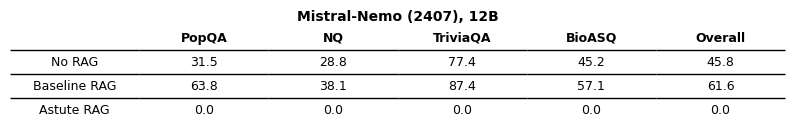

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    'PopQA': [0, 0, 0],
    'NQ': [0, 0, 0],
    'TriviaQA': [0, 0, 0],
    'BioASQ': [0, 0, 0],
    'Overall': [0, 0, 0]
}

#No RAG 정확도 업데이트
for key in data:
    acc = no_rag_accuracy[str(key).lower()]
    data[key][0] = round(acc, 1)
    
# Baseline RAG 정확도로 업데이트
for key in data:
    acc = rag_accuracy[str(key).lower()]
    data[key][1] = round(acc, 1)  

df = pd.DataFrame(data, index=['No RAG', 'Baseline RAG', 'Astute RAG'])

fig, ax = plt.subplots(figsize=(8, 1.5))
ax.axis('off')

col_labels = [''] + list(df.columns)
header_text = [['Mistral-Nemo (2407), 12B', '', '', '', '']]

table = ax.table(
    cellText=[[idx] + list(row) for idx, row in zip(df.index, df.values)],
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for j in range(len(col_labels)):
    table[(0, j)].set_facecolor('#ffffff')
    table[(0, j)].set_text_props(fontweight='bold')
    table[(0, j)].visible_edges = 'B' 

for i in range(1, len(df) + 1):
    for j in range(len(col_labels)):
        table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].visible_edges = 'B' if i < len(df) else ''

plt.text(0.5, 0.95, 'Mistral-Nemo (2407), 12B', ha='center', va='bottom', 
         fontsize=10, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
plt.show()